In [1]:
import os
os.environ['HF_HOME'] = '/data1/malto/cache'

In [2]:
from transformers import Trainer
import torch.nn as nn
import torch

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        p_hall = inputs.pop("p(Hallucination)")
        cond_weights = inputs.pop("C-W")
        #cond_weights = torch.where(cond_weights > 0.5, 1.1, 0.1)
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")[:, 0]
        loss_fn = nn.BCEWithLogitsLoss(reduction='none')
        loss = cond_weights * loss_fn(logits, p_hall)
        loss = loss.mean()
        return (loss, outputs) if return_outputs else loss

    """def prediction_step(self, model, inputs, prediction_loss_only, ignore_keys):
        phall = inputs.pop("p(Hallucination)")
        cw = inputs.pop("C-W")
        loss, logits, labels = super().prediction_step(model, inputs, prediction_loss_only, ignore_keys)
        inputs['p(Hallucination)'] = phall
        inputs['C-W'] = cw
        loss = self.compute_loss(model, inputs)
        return loss, logits, labels"""

/data1/malto/csavelli/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
import evaluate
from transformers import AutoModelForSequenceClassification, AutoTokenizer, TrainingArguments, Trainer, DataCollatorWithPadding
import numpy as np
from pathlib import Path
import scipy

os.environ['TOKENIZERS_PARALLELISM'] = "false"
os.environ["WANDB_DISABLED"] = "true"

BATCH_SIZE = 24
NUM_EPOCHS = 1
BASE_DIR = Path("/data1/malto/shroom/")

FREEZE = True
FROZEN_LAYERS = 22
USE_SEQUENTIAL = True

checkpoint = "microsoft/deberta-v2-xlarge"
#checkpoint = "microsoft/deberta-xlarge-mnli"
#checkpoint = "microsoft/deberta-large-mnli"
#checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
#checkpoint = "microsoft/deberta-v3-base"

tokenizer = AutoTokenizer.from_pretrained(checkpoint)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [7]:
def preprocess_function(examples): # not batched
    model_inputs = tokenizer(examples['hyp'], examples['tgt'] if examples['ref'] != 'src' else examples['src'], truncation=True, max_length=80)
    model_inputs["labels"] = [1 if t == "Hallucination" else 0 for t in examples['labels']]
    return model_inputs

def compute_metrics(eval_pred):
    #print(eval_pred)
    accuracy = evaluate.load("accuracy")
    predictions, labels = eval_pred
    #print(predictions, labels)
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

id2label = {0: "Not Hallucination", 1: "Hallucination"}
label2id = {"Not Hallucination": 0, "Hallucination": 1}

model = AutoModelForSequenceClassification.from_pretrained(
    checkpoint, num_labels=2, id2label=id2label, label2id=label2id, ignore_mismatched_sizes=True
)

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v2-xlarge and are newly initialized: ['classifier.weight', 'classifier.bias', 'pooler.dense.weight', 'pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
model.deberta.encoder.conv.conv.weight.shape[1]

1536

In [5]:
if USE_SEQUENTIAL:
    model.classifier = nn.Sequential(
        nn.Linear(in_features=1024, out_features=2048, bias=True),
        nn.Sigmoid(),
        nn.Linear(in_features=2048, out_features=2, bias=True)
    )


In [6]:
if FREEZE == True and checkpoint.startswith("microsoft"):
    print("freezing...")
    for param in model.deberta.embeddings.parameters():
        param.requires_grad = False
    for param in model.deberta.encoder.layer[:FROZEN_LAYERS].parameters():
        param.requires_grad = False

freezing...


In [7]:
from datasets import load_dataset, concatenate_datasets, DatasetDict
# dataset manipulation

syntetic_test_size_split = 0.01

ds_mt = load_dataset("json", data_files=[str(BASE_DIR / f"train_labeled_MT_SOLAR.model-agnostic.json")])
ds_dm = load_dataset("json", data_files=[str(BASE_DIR / f"train_labeled_DM_SOLAR.model-agnostic.json")])
ds_pg = load_dataset("json", data_files=[str(BASE_DIR / f"train_labeled_PG_SOLAR.model-agnostic.json")])
ds_val = load_dataset("json", data_files=[str(BASE_DIR / f"val.model-agnostic.json")])
ds_val_aware = load_dataset("json", data_files=[str(BASE_DIR / f"val.model-aware.json")])
ds_gpt = load_dataset("json", data_files=str(BASE_DIR / f"transformed_val_model_gpt.json"))

ds_mt = ds_mt.remove_columns([el for el in ds_mt['train'].column_names if el not in ds_val['train'].column_names])['train'].train_test_split(test_size=syntetic_test_size_split)
ds_dm = ds_dm.remove_columns([el for el in ds_dm['train'].column_names if el not in ds_val['train'].column_names])['train'].train_test_split(test_size=syntetic_test_size_split)
ds_pg = ds_pg.remove_columns([el for el in ds_pg['train'].column_names if el not in ds_val['train'].column_names])['train'].train_test_split(test_size=syntetic_test_size_split)
ds_gpt = ds_gpt.remove_columns([el for el in ds_pg['train'].column_names if el not in ds_val['train'].column_names])['train'].train_test_split(test_size=syntetic_test_size_split)


ds = concatenate_datasets([ds_mt['train'], ds_dm['train'], ds_pg['train'], ds_val['train'], ds_gpt['train']])
ds = ds.shuffle()
ds = DatasetDict({
    'train' : ds,
    'test' : ds_val_aware['train'],
})
ds = ds.map(preprocess_function)
ds = ds.remove_columns(['hyp', 'src', 'task', 'ref', 'tgt', 'model', 'labels', 'label'])

ds

Map: 100%|██████████| 30693/30693 [00:05<00:00, 5260.00 examples/s]


DatasetDict({
    train: Dataset({
        features: ['C-W', 'p(Hallucination)', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 30693
    })
    test: Dataset({
        features: ['p(Hallucination)', 'C-W', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 501
    })
})

In [8]:
training_args = TrainingArguments(
    output_dir="/data1/malto/shroom/checkpoint/local_model",
    learning_rate=1e-5,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=NUM_EPOCHS,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="no",
    logging_steps=1,
    report_to="none",
    remove_unused_columns=False,
)

trainer = CustomTrainer(
        model=model,
        args=training_args,
        train_dataset=ds["train"],
        eval_dataset=ds["test"],
        tokenizer=tokenizer,
        data_collator=data_collator,
        #compute_metrics=compute_metrics,
    )

trainer.label_names = []
trainer.can_return_loss = True

array([[<Axes: title={'center': '0'}>]], dtype=object)

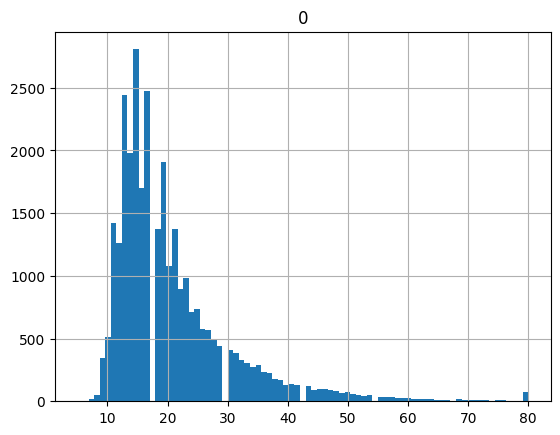

In [9]:
import pandas as pd

df = pd.DataFrame([len(el) for el in ds['train']['input_ids']])
df.hist(bins=81)

In [ ]:
trainer.evaluate()

In [ ]:
def get_accuracy():
    predictions, _, _ = trainer.predict(ds["test"])

    #predictions = scipy.special.softmax(predictions, axis=-1)
    #predictions = np.argmax(predictions, axis=-1)
    predictions = scipy.special.expit(predictions[:, 0])
    predictions = np.where(predictions > 0.5, 0, 1)

    references = np.where(np.array(ds['test']['p(Hallucination)']) > 0.5, 0, 1)

    accuracy = (predictions == references).sum() / predictions.shape[0]
    return accuracy

get_accuracy()

In [ ]:
from IPython.display import clear_output

accs = []
for i in range(1):
    clear_output(wait=True)
    print(i)
    print(accs)
    trainer.train()
    accs.append(get_accuracy())
#clear_output(wait=True)
print(accs)

In [ ]:
import random 

name_model = f"{checkpoint.split('/')[-1]}_{syntetic_test_size_split}_{'frozen' if FREEZE else 'unfrozen'}_{FROZEN_LAYERS}_{BATCH_SIZE}_{NUM_EPOCHS}_{accs[-1].round(3)}_{int(100*random.random())}{'_sequential' if USE_SEQUENTIAL else ''}"

predictions, _, _ = trainer.predict(ds["test"])
predictions = scipy.special.expit(predictions[:, 0])
predictions

df = pd.DataFrame(predictions, columns=[name_model])
df

In [ ]:
ds_test['train'].map(preprocess_function_test)

In [10]:
def preprocess_function_test(examples): # not batched
    model_inputs = tokenizer(examples['hyp'], examples['tgt'], truncation=True, max_length=80)
    return model_inputs

ds_test = load_dataset("json", data_files=[str(BASE_DIR / f"test.model-agnostic.json")])

predictions, _, _ = trainer.predict(ds_test['train'].map(preprocess_function_test).remove_columns(["id", 'tgt', 'task', 'hyp', 'src']))
predictions = scipy.special.expit(predictions[:, 0])
predictions

df = pd.DataFrame(predictions, columns=["crlft_alldata_deberta_xlarge_forzen_22_sequential"])
df

Map: 100%|██████████| 1500/1500 [00:00<00:00, 8219.17 examples/s]
You're using a DebertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


KeyError: 'p(Hallucination)'

: 

In [ ]:
#dataframe = pd.read_csv(f"/data1/malto/shroom/predictions_last.csv")
#dataframe[name_model] = df[name_model]
#dataframe.to_csv(f"/data1/malto/shroom/predictions_last.csv", index=False)

df.to_csv(f"/data1/malto/shroom/crlft.csv", index=False)

# Submission Generation

In [ ]:
ds_test = load_dataset("json", data_files=[str(BASE_DIR / "test.model-agnostic.json")])
ds_test

In [ ]:
def preprocess_function_test(examples): # not batched
    model_inputs = tokenizer(examples['hyp'], examples['tgt'], truncation=True, max_length=80)
    return model_inputs
def add_columns(examples):
    return {'p(Hallucination)' : 0.01, 'C-W': 1.01}

ds_test = ds_test.map(preprocess_function_test).remove_columns(['tgt', 'task', 'src', 'id', 'hyp']).map(add_columns, batched=False)

In [ ]:
import scipy
predictions, _, _ = trainer.predict(ds_test["train"])

probabilities = scipy.special.expit(predictions[:, 0])
predictions = np.where(probabilities > 0.5, "Hallucination", "Not Hallucination")

In [ ]:
import pandas as pd
df = pd.read_csv(BASE_DIR / "sequential.csv")
df

In [ ]:
ds_test_new = load_dataset("json", data_files=[str(BASE_DIR / "test.model-agnostic.json")])

global count
count = 0
def add_predictions(examples):
    global count
    prob = probabilities[count]
    pred = predictions[count]
    count += 1
    return {'p(Hallucination)' : prob, 'label' : pred}
ds_test_new = ds_test_new.map(add_predictions).remove_columns(['tgt', 'task', 'src', 'hyp'])

In [ ]:
ds_test_new['train'].to_json(str(BASE_DIR / "submission.json"))

In [ ]:
import json
label = "a_lr1e-4"

l = [el for el in ds_test_new['train']]
with open(BASE_DIR / f"submission_{label}.json", "w", encoding="utf-8") as f:
    f.write(json.dumps(l))

## Ensemble

In [ ]:
# open json file 
f = open(BASE_DIR / "submission_a_lr1e-4.json",)
f = json.load(f)
f1 = open(BASE_DIR / "submission_a.json",)
f1 = json.load(f1)

# dataframe from json file 
df = pd.DataFrame(f)
df1 = pd.DataFrame(f1)
df1 = df1.rename(columns={'p(Hallucination)': 'p(Hallucination)_a'})

final_df = pd.concat([df, df1], axis=1)

# for each row evaluate correlation between p(Hallucination) and p(Hallucination)_{label}

from scipy.stats import pearsonr
pearsonr(final_df['p(Hallucination)'], final_df['p(Hallucination)_a'])

In [ ]:
ids = np.linspace(0, 1000, 1001, dtype=int)
 
p_hallucination = np.random.rand(1001)
labels = np.where(p_hallucination > 0.5, "Hallucination", "Not Hallucination")

i = 0 

ids[0], p_hallucination[0], labels[0]

In [ ]:
# make 5 dataframes with 5 different seeds of 3 columns (id, p(Hallucination), label), where id is shared across all 5 dataframes
import pandas as pd 

ids = np.linspace(0, 1000, 1001, dtype=int)
dataframes = []

for i in range(5): 
    p_hallucination = np.random.rand(1001)
    labels = np.where(p_hallucination > 0.5, "Hallucination", "Not Hallucination")
    df = pd.DataFrame({f"id_{i}": ids, f"p(Hallucination)_{i}": p_hallucination, f"label_{i}": labels})
    dataframes.append(df)


In [ ]:
def make_ensemble(dataframes: list) -> pd.DataFrame:
    # the function works with 5 dataframes of 3 columns (id, p(Hallucination), label), where id is shared across all 5 dataframes    
    df = pd.concat(dataframes, axis=1)

    assert df['id_0'].equals(df['id_1'])
    assert df['id_0'].equals(df['id_2'])
    assert df['id_0'].equals(df['id_3'])
    assert df['id_0'].equals(df['id_4'])
    df = df.drop(columns=['id_1', 'id_2', 'id_3', 'id_4'])
    df.rename(columns={'id_0': 'id'}, inplace=True)

    df['p(Hallucination)'] = df.loc[:, df.columns.str.startswith('p(Hallucination)')].mean(axis=1)
    df = df.drop(columns=['p(Hallucination)_0', 'p(Hallucination)_1', 'p(Hallucination)_2', 'p(Hallucination)_3', 'p(Hallucination)_4', 'label_0', 'label_1', 'label_2', 'label_3', 'label_4'])
    
    df['label'] = np.where(df['p(Hallucination)'] > 0.5, "Hallucination", "Not Hallucination")
    return df

In [ ]:
ds_ensemble = make_ensemble(dataframes)

In [ ]:
import json

l = [el for el in ds_ensemble]
with open(BASE_DIR / "ensemble_submission.json", "w", encoding="utf-8") as f:
    f.write(json.dumps(l))

# Output analysis

In [ ]:
dataframe['Ground Truth'] = ds_val_aware['train']['p(Hallucination)']

In [ ]:
dataframe = pd.read_csv(f"/data1/malto/shroom/predictions_last.csv")
dataframe

In [ ]:
dataframe['avg'] = (dataframe['deberta-large-mnli_1_frozen_22_48_1_0.743_63_sequential'] + dataframe['deberta-v3-base_0.8_frozen_15_48_5_0.681_2']) / 2

In [ ]:
# correlation matrix of dataframe 
import seaborn as sn
import matplotlib.pyplot as plt

corrMatrix = dataframe.corr(method='spearman')
sn.heatmap(corrMatrix, annot=True)
plt.show()